In [53]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment
import noisereduce as nr
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [54]:
df = pd.read_csv('data/songs_wav.csv')

logging.info(f'Data Length: {len(df)}')
df.head()

2024-11-27 17:21:29,168 - INFO - Data Length: 297


,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,243,https://www.youtube.com/watch?v=lAVi2OE2bRY,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
1,VIDEO LIRIK- BUNGONG JEUMPA,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,264,https://www.youtube.com/watch?v=tgc0dBKcqhE,datasets/songs/video_lirik_bungong_jeumpa.mp3,datasets/wav_songs/video_lirik_bungong_jeumpa.wav
2,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,160,https://www.youtube.com/watch?v=RjI7W_XmzLM,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
3,Bungong Jeumpa,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,259,https://www.youtube.com/watch?v=_M1ZNoY99nk,datasets/songs/bungong_jeumpa.mp3,datasets/wav_songs/bungong_jeumpa.wav
4,Bungong Jeumpa - Tania,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,218,https://www.youtube.com/watch?v=ZfZxIR9vRmk,datasets/songs/bungong_jeumpa_tania.mp3,datasets/wav_songs/bungong_jeumpa_tania.wav


In [55]:
def get_duration(file_path):
    if pd.isna(file_path):  # Menangani NaN atau None
        print('Skipping: file path is NaN or None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    
    logging.info(f'sample rate: {sr}, duration: {duration}')
    
    return sr, duration

In [56]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))

2024-11-27 17:21:29,582 - INFO - sample rate: 22050, duration: 242.13768707482993
2024-11-27 17:21:29,988 - INFO - sample rate: 22050, duration: 263.2214058956916
2024-11-27 17:21:30,349 - INFO - sample rate: 22050, duration: 159.79972789115646
2024-11-27 17:21:30,742 - INFO - sample rate: 22050, duration: 258.14639455782316
2024-11-27 17:21:31,091 - INFO - sample rate: 22050, duration: 217.40843537414966
2024-11-27 17:21:31,400 - INFO - sample rate: 22050, duration: 209.62975056689342
2024-11-27 17:21:31,821 - INFO - sample rate: 22050, duration: 260.92263038548754
2024-11-27 17:21:32,145 - INFO - sample rate: 22050, duration: 255.97678004535146
2024-11-27 17:21:32,488 - INFO - sample rate: 22050, duration: 263.26784580498867
2024-11-27 17:21:32,774 - INFO - sample rate: 22050, duration: 214.7613605442177
2024-11-27 17:21:33,171 - INFO - sample rate: 22050, duration: 316.3022222222222
2024-11-27 17:21:33,523 - INFO - sample rate: 22050, duration: 258.007074829932
2024-11-27 17:21:34,1

In [83]:
df.describe()

,duration,sample_rate,duration_sec
count,297.000000,297.0,297.000000
mean,251.454545,22050.0,250.933203
std,79.932988,0.0,80.154140
min,35.000000,22050.0,34.342313
25%,199.000000,22050.0,198.460952
50%,255.000000,22050.0,254.467483
75%,300.000000,22050.0,297.981678
max,498.000000,22050.0,498.008526


In [84]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        title = row['title']
        region = row['region']
        keyword = row['keyword']
        nama_lagu = row['nama_lagu']
        
        # Cek jika wav_path adalah string dan file yang valid
        if isinstance(wav_path, str) and os.path.isfile(wav_path):
            norm_title = normalized_yt_title(nama_lagu)
            norm_region = region.lower().replace(' ', '_')
            output_dir = os.path.join(output_base_folder, norm_region, norm_title + "_" + str(index))
            
            audio = AudioSegment.from_wav(wav_path)
            total_duration = len(audio) / 1000  # Durasi dalam detik
            segment_duration = 30
            num_segments = int(total_duration // segment_duration)


            os.makedirs(output_dir, exist_ok=True)

            for i in range(num_segments):
                start_time = i * segment_duration * 1000
                end_time = (i + 1) * segment_duration * 1000
                segment = audio[start_time:end_time]
                
                segment_file = os.path.join(output_dir, f"segment{i + 1}.wav")
                segment.export(segment_file, format="wav")
                
                split_result.append({
                    'title': nama_lagu,
                    'region': region,
                    'keyword': keyword,
                    '30s_path': segment_file
                })
            print(f"Saved {num_segments} segments in {norm_region} for {title} at: {output_dir}")
        else:
            print(f"Invalid wav_path at index {index}: {wav_path}")


In [85]:
split_songs_to_segments(df)

Saved 8 segments in aceh for Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita at: datasets/30s_segments\aceh\bungong_jeumpa_0
Saved 8 segments in aceh for VIDEO LIRIK- BUNGONG JEUMPA at: datasets/30s_segments\aceh\bungong_jeumpa_1
Saved 5 segments in aceh for Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh) at: datasets/30s_segments\aceh\bungong_jeumpa_2
Saved 8 segments in aceh for Bungong Jeumpa at: datasets/30s_segments\aceh\bungong_jeumpa_3
Saved 7 segments in aceh for Bungong Jeumpa - Tania at: datasets/30s_segments\aceh\bungong_jeumpa_4
Saved 6 segments in aceh for Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya at: datasets/30s_segments\aceh\bungong_jeumpa_5
Saved 8 segments in aceh for KAKA ALFARISI - BUNGONG JEUMPA (OFFICIAL VIDEO) at: datasets/30s_segments\aceh\bungong_jeumpa_6
Saved 8 segments in aceh for Bungong Jeumpa | Lagu Daerah Aceh | Budaya Indonesia | Dongeng Kita at: datasets/30s_segments\aceh\bungong_jeumpa_7
Saved 8 segments in aceh f

In [86]:
df_res = pd.DataFrame(split_result)
df_res.head()

,title,region,keyword,30s_path
0,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
1,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
2,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
3,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...
4,Bungong Jeumpa,Aceh,Lagu Daerah Bungong Jeumpa asal Aceh,datasets/30s_segments\aceh\bungong_jeumpa_0\se...


In [ ]:
# save
df_res.to_csv('data/30s_segments.csv', index=False)

### Feature Extraction

In [88]:
def extract_mfcc_features(wav_path, n_mfcc=13):
    y, sr = librosa.load(wav_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

def extract_spectogram_features(wav_path):
    y, sr = librosa.load(wav_path)
    S = np.abs(librosa.stft(y))
    S_mean = np.mean(S.T, axis=0)
    return S_mean

def extract_features(wav_path):
    mfcc = extract_mfcc_features(wav_path)
    spectogram = extract_spectogram_features(wav_path)
    combined_features = np.concatenate((mfcc, spectogram))
    return combined_features

In [62]:
# df_res['mfcc_features'] = df_res['30s_path'].apply(extract_mfcc_features)
# df_res['spectogram_features'] = df_res['30s_path'].apply(extract_spectogram_features)
# df_res.head()

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

### RANDOM FOREST

In [90]:
from sklearn.model_selection import train_test_split

# Prepare the data
X = []
y = []

for index, row in df_res.iterrows():
    wav_path = row['30s_path']
    label = row['title']
    
    features = extract_features(wav_path)
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [65]:
import os
import shutil

# Delete segment file to save space
segment_dir = 'datasets/30s_segments'

if os.path.exists(segment_dir):
    shutil.rmtree(segment_dir)
    print(f"Deleted directory: {segment_dir}")
else:
    print(f"Directory does not exist: {segment_dir}")

Deleted directory: datasets/30s_segments


In [97]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (2335, 1038), y shape: (2335,)


In [67]:
from sklearn.ensemble import RandomForestClassifier
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 95.88%
F1 Score: 95.88%
Precision Score: 95.93%
Recall Score: 95.88%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        59
 Alam Wisata Pulau Bangka       1.00      0.94      0.97        77
              Aneuk Yatim       1.00      1.00      1.00        63
           Bungong Jeumpa       0.94      0.97      0.95        62
            Dayung Sampan       1.00      1.00      1.00        60
                 Dewa Ayu       0.87      0.91      0.89        45
                      Ibo       1.00      1.00      1.00        75
        Icak-Icak Dek Tau       1.00      1.00      1.00        57
            Jambo – Jambo       1.00      1.00      1.00        56
            Jereh Bu Guru       1.00      1.00      1.00        56
               Jibeak Weo       1.00      1.00      1.00        55
Lagu Men Sahang Lah Mirah

In [69]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 83.51%
F1 Score: 82.85%
Precision Score: 83.46%
Recall Score: 83.51%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.96      0.88      0.92        26
 Alam Wisata Pulau Bangka       0.82      0.88      0.85        16
              Aneuk Yatim       0.89      0.89      0.89        27
           Bungong Jeumpa       0.85      1.00      0.92        11
            Dayung Sampan       0.87      1.00      0.93        13
                 Dewa Ayu       0.62      0.38      0.48        13
                      Ibo       1.00      0.92      0.96        26
        Icak-Icak Dek Tau       0.88      1.00      0.93        14
            Jambo – Jambo       0.87      0.93      0.90        14
            Jereh Bu Guru       1.00      1.00      1.00         8
               Jibeak Weo       0.80      1.00      0.89         8
Lagu Men Sahang Lah Mirah 

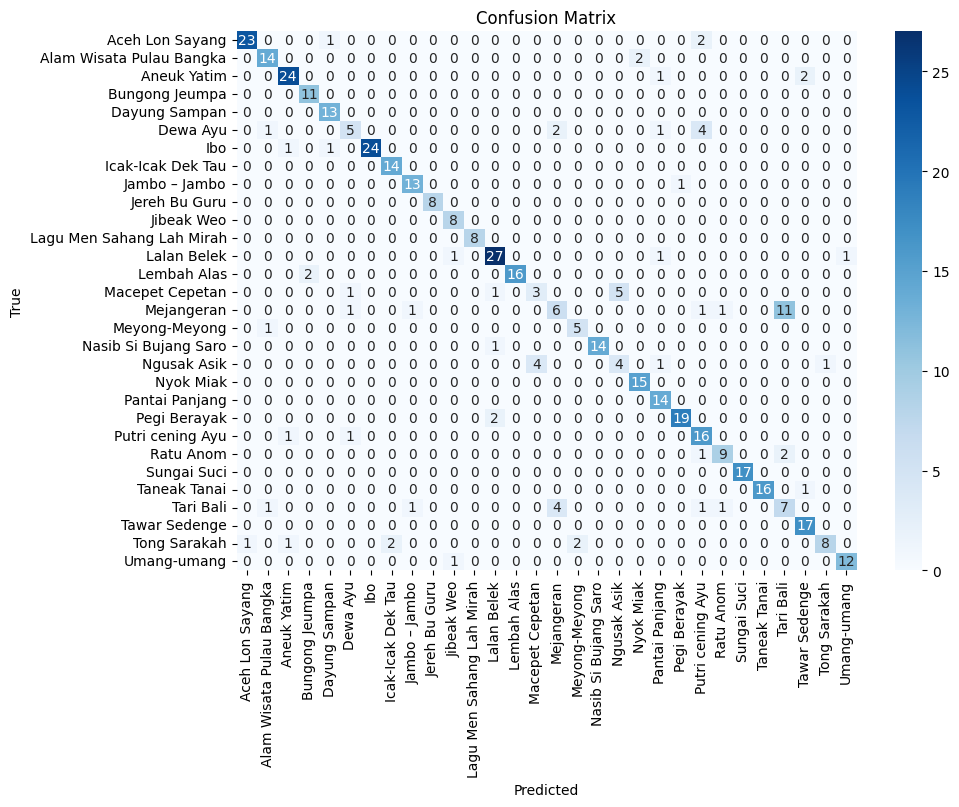

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [71]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=7.5)
svm_model.fit(X_train, y_train)


SVC(C=7.5, kernel='linear', random_state=42)

In [72]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 95.88%
F1 Score: 95.89%
Precision Score: 96.07%
Recall Score: 95.88%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        59
 Alam Wisata Pulau Bangka       1.00      0.94      0.97        77
              Aneuk Yatim       1.00      1.00      1.00        63
           Bungong Jeumpa       0.91      1.00      0.95        62
            Dayung Sampan       1.00      1.00      1.00        60
                 Dewa Ayu       1.00      0.82      0.90        45
                      Ibo       1.00      1.00      1.00        75
        Icak-Icak Dek Tau       1.00      1.00      1.00        57
            Jambo – Jambo       1.00      1.00      1.00        56
            Jereh Bu Guru       1.00      1.00      1.00        56
               Jibeak Weo       1.00      1.00      1.00        55
Lagu Men Sahang Lah Mirah

In [73]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 84.80%
F1 Score: 84.93%
Precision Score: 86.09%
Recall Score: 84.80%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      0.85      0.92        26
 Alam Wisata Pulau Bangka       0.88      0.88      0.88        16
              Aneuk Yatim       1.00      0.85      0.92        27
           Bungong Jeumpa       0.85      1.00      0.92        11
            Dayung Sampan       0.87      1.00      0.93        13
                 Dewa Ayu       0.75      0.46      0.57        13
                      Ibo       0.92      0.92      0.92        26
        Icak-Icak Dek Tau       0.88      1.00      0.93        14
            Jambo – Jambo       1.00      0.86      0.92        14
            Jereh Bu Guru       0.80      1.00      0.89         8
               Jibeak Weo       1.00      1.00      1.00         8
Lagu Men Sahang Lah Mirah 

### Decision Tree's

In [74]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [75]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 95.88%
F1 Score: 95.66%
Precision Score: 96.70%
Recall Score: 95.88%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        59
 Alam Wisata Pulau Bangka       0.94      1.00      0.97        77
              Aneuk Yatim       1.00      1.00      1.00        63
           Bungong Jeumpa       0.91      1.00      0.95        62
            Dayung Sampan       1.00      1.00      1.00        60
                 Dewa Ayu       0.80      1.00      0.89        45
                      Ibo       1.00      1.00      1.00        75
        Icak-Icak Dek Tau       1.00      1.00      1.00        57
            Jambo – Jambo       1.00      1.00      1.00        56
            Jereh Bu Guru       1.00      1.00      1.00        56
               Jibeak Weo       1.00      1.00      1.00        55
Lagu Men Sahang Lah Mirah

In [76]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 60.81%
F1 Score: 60.78%
Precision Score: 64.10%
Recall Score: 60.81%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.71      0.38      0.50        26
 Alam Wisata Pulau Bangka       0.67      0.62      0.65        16
              Aneuk Yatim       0.81      0.48      0.60        27
           Bungong Jeumpa       0.53      0.82      0.64        11
            Dayung Sampan       0.56      0.69      0.62        13
                 Dewa Ayu       0.20      0.15      0.17        13
                      Ibo       0.71      0.58      0.64        26
        Icak-Icak Dek Tau       0.61      0.79      0.69        14
            Jambo – Jambo       0.83      0.71      0.77        14
            Jereh Bu Guru       0.35      0.88      0.50         8
               Jibeak Weo       0.47      1.00      0.64         8
Lagu Men Sahang Lah Mirah 

### Save Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# One-hot encode the labels
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\naufa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
print(y[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [79]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0433 - loss: 6.3215 - val_accuracy: 0.1135 - val_loss: 3.3011
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0598 - loss: 3.4588 - val_accuracy: 0.0899 - val_loss: 3.2165
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1000 - loss: 3.2649 - val_accuracy: 0.2248 - val_loss: 3.0808
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1013 - loss: 3.2056 - val_accuracy: 0.2484 - val_loss: 2.9320
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1405 - loss: 3.0542 - val_accuracy: 0.3041 - val_loss: 2.7397
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1887 - loss: 2.8691 - val_accuracy: 0.3233 - val_loss: 2.5806
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2341 - loss: 2.7139 - val_accuracy: 0.3640 - val_loss: 2.4171
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2774 - loss: 2.5877 - val_accuracy: 0.4347 - v

Test Accuracy: 87.58%


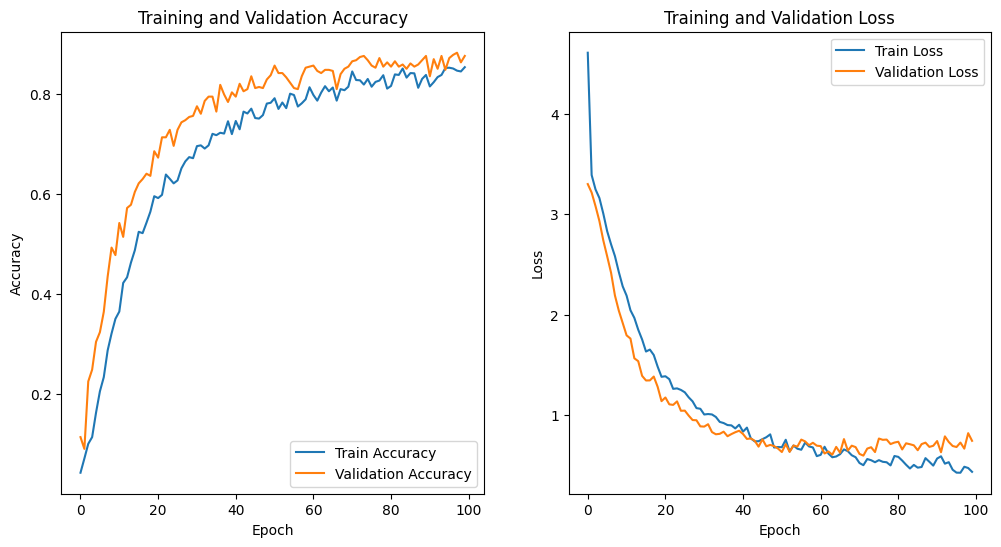

In [80]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")

# plot the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()